In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV

In [2]:
foe = pd.read_csv("FOE.csv")

In [3]:
#Taking a look at our data
foe.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,0.0,2.722222,2.685185,2.685185,1.450476,47925
1,1980-03-18,0.0,2.703704,2.666667,2.685185,1.450476,77625
2,1980-03-19,0.0,2.703704,2.666667,2.703704,1.460480,35775
3,1980-03-20,0.0,2.777778,2.703704,2.722222,1.470483,42525
4,1980-03-21,0.0,2.777778,2.740741,2.740741,1.480487,37125


In [4]:
#numerical value summary statistics
foe[['Open', 'High', 'Low', 'Close', 'Adj Close']].describe()

,Open,High,Low,Close,Adj Close
count,10590.000000,10590.000000,10590.000000,10590.000000,10590.000000
mean,13.607281,14.631222,14.240872,14.439353,11.952665
std,8.521814,7.381201,7.230212,7.309994,6.597625
min,0.000000,1.010000,0.810000,0.860000,0.860000
25%,7.072500,7.740000,7.420000,7.611111,5.995661
50%,14.860000,15.080000,14.666667,14.865000,12.818146
75%,20.610001,20.847500,20.333332,20.620001,17.534573
max,30.250000,30.937500,30.000000,30.549999,25.350000


In [5]:
foe.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [6]:
#converting the Date into datetime
foe['Date'] = pd.to_datetime(foe.Date, format='%Y-%m-%d')
foe.set_index('Date', inplace=True)

In [7]:
#subset with only date and adj close columns
foe_sub = pd.DataFrame(foe[['Adj Close']])

In [8]:
foe_sub.head()

,Adj Close
Date,
1980-03-17,1.450476
1980-03-18,1.450476
1980-03-19,1.460480
1980-03-20,1.470483
1980-03-21,1.480487


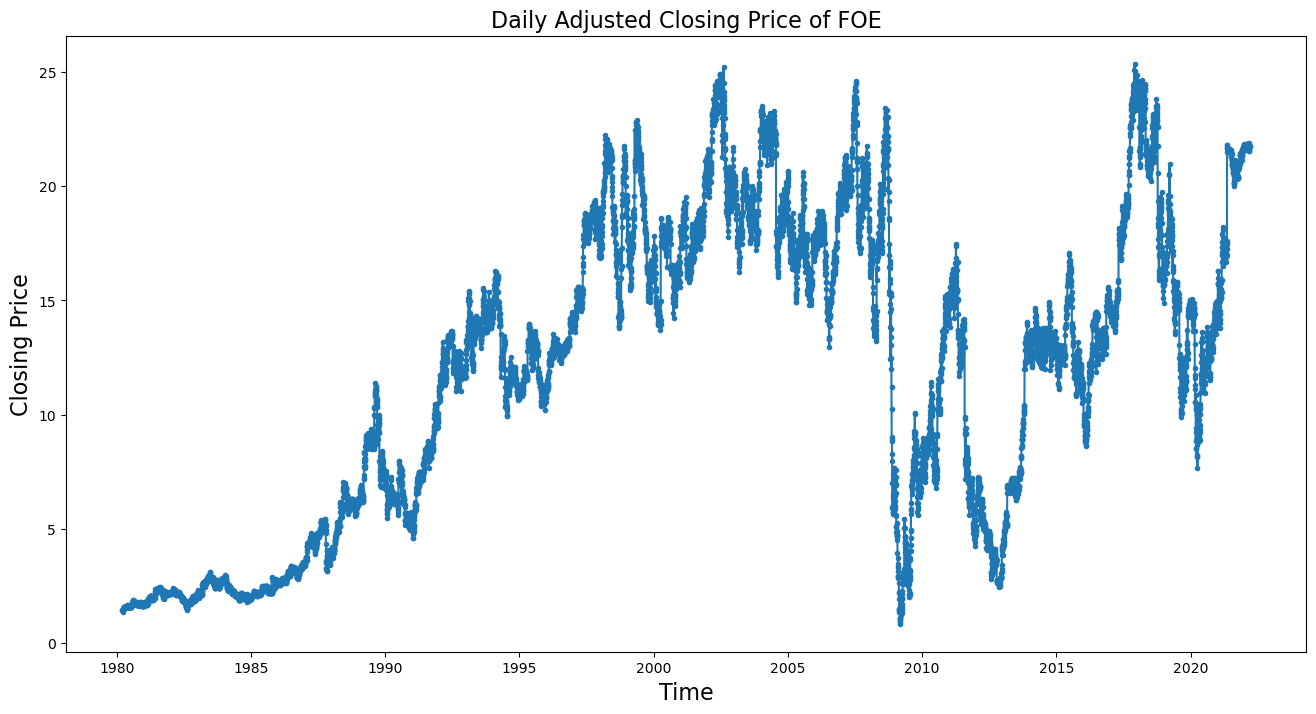

In [9]:
#function to plot a line graph
def line_g(df,x,y,title):
    plt.figure(figsize=(16,8))
    plt.plot(x, y, ".-", data = df)
    plt.title(title, fontsize = 16)
    plt.xlabel("Time", fontsize = 16)
    plt.ylabel("Closing Price", fontsize = 16)
line_g(foe_sub,foe_sub.index, 'Adj Close', "Daily Adjusted Closing Price of FOE")

In [11]:
def create_lagged_features(data, lag=1):
    lagged_data = data.copy()
    for i in range(1, lag + 1):
        lagged_data[f"lag_{i}"] = lagged_data['Adj Close'].shift(i)
    return lagged_data

lag = 30
lagged_data = create_lagged_features(foe_sub, lag)
lagged_data.dropna(inplace=True)

In [34]:
train_data = lagged_data.loc['2016-01-01':'2018-12-31']
test_data = lagged_data.loc['2019-01-01':]

X_train = train_data.drop('Adj Close', axis=1)
y_train = train_data['Adj Close']
X_test = test_data.drop('Adj Close', axis=1)
y_test = test_data['Adj Close']

In [39]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1)

tscv = TimeSeriesSplit(n_splits=25)

params = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 150],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=params,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=tscv,
    verbose=1,
)

random_search.fit(X_train, y_train)
best_params = random_search.best_params_

Fitting 25 folds for each of 10 candidates, totalling 250 fits


In [40]:
best_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', n_jobs=-1)
best_model.fit(X_train, y_train)

predictions = best_model.predict(X_test)

In [41]:
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.2333144339282325


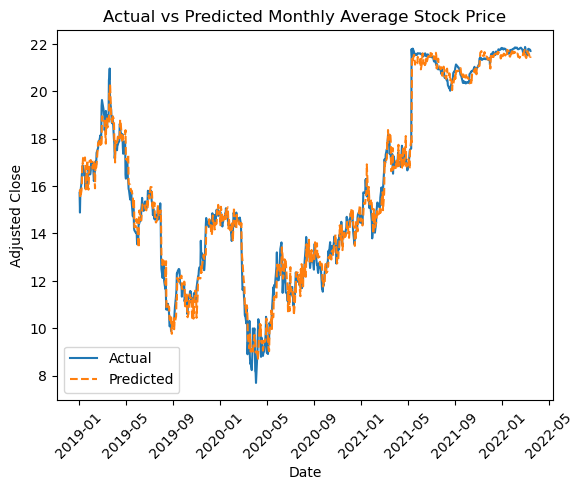

In [42]:
import matplotlib.pyplot as plt

plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, predictions, label='Predicted', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Adjusted Close')
plt.title('Actual vs Predicted Monthly Average Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

After multiple attempts, the model is still unusually accurate and I can't seems to find what is wrong with the code. I am aware that there is an error somewhere but I am unfortunately not able to identify where.